In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/berlin-database-of-emotional-speech-emodb/wav/15a04Fd.wav
/kaggle/input/berlin-database-of-emotional-speech-emodb/wav/13b02Fb.wav
/kaggle/input/berlin-database-of-emotional-speech-emodb/wav/09b01Wb.wav
/kaggle/input/berlin-database-of-emotional-speech-emodb/wav/15a01Wa.wav
/kaggle/input/berlin-database-of-emotional-speech-emodb/wav/14a05Wa.wav
/kaggle/input/berlin-database-of-emotional-speech-emodb/wav/03a05Aa.wav
/kaggle/input/berlin-database-of-emotional-speech-emodb/wav/11a04Wc.wav
/kaggle/input/berlin-database-of-emotional-speech-emodb/wav/09a05Tb.wav
/kaggle/input/berlin-database-of-emotional-speech-emodb/wav/12a01Wc.wav
/kaggle/input/berlin-database-of-emotional-speech-emodb/wav/12a04Wc.wav
/kaggle/input/berlin-database-of-emotional-speech-emodb/wav/09a04La.wav
/kaggle/input/berlin-database-of-emotional-speech-emodb/wav/08b02Nb.wav
/kaggle/input/berlin-database-of-emotional-speech-emodb/wav/12b10Wa.wav
/kaggle/input/berlin-database-of-emotional-speech-emodb/wav/15a0

In [2]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, LSTM, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import os
import librosa
import numpy as np
import pandas as pd


2024-07-18 17:52:11.212271: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-18 17:52:11.212330: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-18 17:52:11.213983: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
tf.random.set_seed(42)

# Paths to datasets
BerlinDB = "/kaggle/input/berlin-database-of-emotional-speech-emodb"
Tess_path = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"



In [4]:
# Load EmoDB dataset
berlin_directory_list = os.listdir(BerlinDB)

file_emotion = []
file_path = []

for dir in berlin_directory_list:
    directories = os.listdir(BerlinDB + "/" + dir)
    
    for file in directories:
        file_path.append(BerlinDB + "/wav/" +file)
        part = file.split(".")[0]
        ele = part[5]
        if ele=='W':
            file_emotion.append('angry')
        elif ele=='E':
            file_emotion.append('disgust')
        elif ele=='A':
            file_emotion.append('fear')
        elif ele=='F':
            file_emotion.append('happy')
        elif ele=='N':
            file_emotion.append('neutral')
        elif ele=='T':
            file_emotion.append('sad')
        else:
            file_emotion.append('boredom')

# DataFrame for EmoDB
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Berlin_df = pd.concat([emotion_df, path_df], axis=1)



In [5]:
# Load TESS dataset
Tess_dir_list = os.listdir(Tess_path)
emotions_tess = []
path_tess = []

for it in Tess_dir_list:
    directories = os.listdir(Tess_path + '/' + it)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            emotions_tess.append('surprise')
        else:
            emotions_tess.append(part)
        path_tess.append(Tess_path + it + '/' + file)
        
# DataFrame for TESS
emotion_tess_df = pd.DataFrame(emotions_tess, columns=['Emotions'])
path_tess_df = pd.DataFrame(path_tess, columns=['Path'])
Tess_df = pd.concat([emotion_tess_df, path_tess_df], axis=1)



In [6]:
# Combine datasets
combined_df = pd.concat([Berlin_df, Tess_df], ignore_index=True)



In [7]:
# Display the combined DataFrame
combined_df.head()


,Emotions,Path
0,happy,/kaggle/input/berlin-database-of-emotional-spe...
1,happy,/kaggle/input/berlin-database-of-emotional-spe...
2,angry,/kaggle/input/berlin-database-of-emotional-spe...
3,angry,/kaggle/input/berlin-database-of-emotional-spe...
4,angry,/kaggle/input/berlin-database-of-emotional-spe...


In [8]:
combined_df['Emotions'].value_counts()

Emotions
angry       527
neutral     479
happy       471
fear        469
sad         462
disgust     446
surprise    400
boredom      81
Name: count, dtype: int64

In [9]:
# Remove 'boredom' values
combined_df = combined_df[combined_df['Emotions'] != 'boredom']

In [10]:
# Function to sample 400 values per emotion
def balance_emotions(df, num_samples=400):
    balanced_df = pd.DataFrame(columns=df.columns)
    for emotion in df['Emotions'].unique():
        emotion_df = df[df['Emotions'] == emotion]
        if len(emotion_df) >= num_samples:
            sampled_df = emotion_df.sample(n=num_samples, random_state=42)
        else:
            sampled_df = emotion_df
        balanced_df = pd.concat([balanced_df, sampled_df])
    return balanced_df



In [11]:
# Balance the DataFrame
balanced_df = balance_emotions(combined_df)

# Shuffle the DataFrame to mix the samples
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [12]:
# Display the value counts to verify
print(balanced_df['Emotions'].value_counts())


Emotions
fear        400
angry       400
disgust     400
neutral     400
sad         400
surprise    400
happy       400
Name: count, dtype: int64


In [13]:
balanced_df.head()

,Emotions,Path
0,fear,/kaggle/input/toronto-emotional-speech-set-tes...
1,angry,/kaggle/input/toronto-emotional-speech-set-tes...
2,disgust,/kaggle/input/toronto-emotional-speech-set-tes...
3,fear,/kaggle/input/toronto-emotional-speech-set-tes...
4,neutral,/kaggle/input/toronto-emotional-speech-set-tes...


DATA PREPROCESSING & AUGMENTATION


In [14]:
data,sr = librosa.load(path_tess[0])
sr

22050

In [15]:
# Preprocessing function
def preprocess_audio(data, sampling_rate):
    data = librosa.util.normalize(data)
    data, _ = librosa.effects.trim(data)
    target_length = 5 * sampling_rate
    if len(data) > target_length:
        data = data[:target_length]
    else:
        padding = target_length - len(data)
        data = np.pad(data, (0, padding), 'constant', constant_values=(0, 0))
    return data

In [16]:
# Function for noise augmentation
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

# Function for stretch augmentation
def stretch(data, rate=0.8):
    stretched_data = librosa.effects.time_stretch(data, rate=rate)
    if len(stretched_data) > len(data):
        stretched_data = stretched_data[:len(data)]
    else:
        stretched_data = np.pad(stretched_data, (0, len(data) - len(stretched_data)), 'constant')
    return stretched_data

# Function for shift augmentation
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

# Function for pitch augmentation
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)


In [17]:
# Function to apply augmentation to each audio file
def apply_augmentation(data, sampling_rate):
    augmented_data = []
    augmentations = [noise, stretch, shift, pitch]
    for aug in augmentations:
        if aug == pitch:
            augmented_audio = aug(data.copy(), sampling_rate)
        else:
            augmented_audio = aug(data.copy())
        augmented_data.append(augmented_audio)
    return augmented_data

In [18]:
def extract_features(audio_data, sampling_rate):
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sampling_rate, n_mfcc=40)
    mfccs = np.mean(mfccs.T, axis=0)
    
    mel = librosa.feature.melspectrogram(y=audio_data, sr=sampling_rate)
    mel = np.mean(mel.T, axis=0)[:40]  # Ensures only 40 Mel features are used
    
    chroma = librosa.feature.chroma_stft(y=audio_data, sr=sampling_rate)
    chroma = np.mean(chroma.T, axis=0)
    
    features = np.hstack([mfccs, mel, chroma])  # Concatenates the features into a single array
    
    return features


In [19]:
# Set sampling rate
sampling_rate = 22050

In [20]:
# Preprocess and augment the data, then extract features
features_list = []

for index, row in balanced_df.iterrows():
    file_path = row['Path']
    data, sr = librosa.load(file_path, sr=sampling_rate)
    preprocessed_audio = preprocess_audio(data, sampling_rate)
    
    # Original and augmented data
    augmented_audios = apply_augmentation(preprocessed_audio, sampling_rate)
    all_audios = [preprocessed_audio] + list(augmented_audios)
    
    for audio in all_audios:
        features = extract_features(audio, sampling_rate)
        # Debugging: Print the shape of extracted features
        print(f"Extracted features shape: {features.shape}")
        features_list.append([row['Emotions']] + list(features))

# Debugging: Print lengths of all feature entries
for i, entry in enumerate(features_list[:5]):  # Print first 5 entries for a quick check
    print(f"Entry {i} length: {len(entry)}")


Extracted features shape: (92,)
Extracted features shape: (92,)
Extracted features shape: (92,)
Extracted features shape: (92,)
Extracted features shape: (92,)
Extracted features shape: (92,)
Extracted features shape: (92,)
Extracted features shape: (92,)
Extracted features shape: (92,)
Extracted features shape: (92,)
Extracted features shape: (92,)
Extracted features shape: (92,)
Extracted features shape: (92,)
Extracted features shape: (92,)
Extracted features shape: (92,)
Extracted features shape: (92,)
Extracted features shape: (92,)
Extracted features shape: (92,)
Extracted features shape: (92,)
Extracted features shape: (92,)
Extracted features shape: (92,)
Extracted features shape: (92,)
Extracted features shape: (92,)
Extracted features shape: (92,)
Extracted features shape: (92,)
Extracted features shape: (92,)
Extracted features shape: (92,)
Extracted features shape: (92,)
Extracted features shape: (92,)
Extracted features shape: (92,)
Extracted features shape: (92,)
Extracte

In [21]:
# Create a DataFrame with the extracted features
feature_columns = [f'mfcc_{i}' for i in range(1, 41)] + [f'mel_{i}' for i in range(40)] + [f'chroma_{i}' for i in range(12)]
print(f"Expected number of columns: {len(['Emotions'] + feature_columns)}")


Expected number of columns: 93


In [23]:
features_df = pd.DataFrame(features_list, columns=['Emotions'] + feature_columns)


In [24]:
features_df

,Emotions,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,...,chroma_2,chroma_3,chroma_4,chroma_5,chroma_6,chroma_7,chroma_8,chroma_9,chroma_10,chroma_11
0,fear,-416.184753,9.303591,-5.212052,3.121031,-3.544912,1.586130,1.133472,-2.138625,-2.555212,...,0.165789,0.132423,0.090862,0.089636,0.118440,0.111575,0.088532,0.100011,0.130233,0.159927
1,fear,-246.715677,2.637040,-2.665352,1.701521,-1.907454,-0.765639,-0.209347,-2.451303,-2.001148,...,0.711321,0.710329,0.695653,0.627601,0.577097,0.591127,0.577157,0.582274,0.615775,0.653807
2,fear,-411.824249,11.262563,-7.683568,3.126846,-4.295904,1.656000,0.536650,-3.009583,-3.588538,...,0.204370,0.154361,0.103782,0.124163,0.159601,0.129684,0.108817,0.132894,0.188089,0.213177
3,fear,-414.680206,9.241825,-4.963193,3.384374,-3.529356,1.712796,1.143988,-2.152555,-2.524286,...,0.174199,0.135836,0.095191,0.092940,0.121885,0.121278,0.097862,0.104744,0.134163,0.167072
4,fear,-442.635193,8.506081,-5.553578,1.634727,-3.216821,1.579399,0.448013,-3.338621,-1.439709,...,0.177478,0.181499,0.124140,0.088897,0.108460,0.137194,0.117690,0.090592,0.098777,0.147643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,fear,-415.352539,16.930027,1.881823,-6.666241,1.319227,0.236913,-4.033497,-0.292697,-6.008443,...,0.188505,0.109233,0.065520,0.065164,0.094161,0.077865,0.074244,0.073123,0.090488,0.112812
13996,fear,-204.420813,8.145140,1.403662,-4.538797,0.003373,0.212349,-2.557545,-2.225799,-3.604318,...,0.766813,0.706136,0.677502,0.640873,0.598545,0.595216,0.602945,0.617732,0.638560,0.682435
13997,fear,-412.858795,22.571838,1.927206,-8.997842,1.488522,0.182654,-5.229992,-1.192162,-7.697329,...,0.234824,0.147157,0.094835,0.092225,0.132313,0.112348,0.102592,0.102551,0.118495,0.139755
13998,fear,-411.782501,16.960819,1.919249,-6.646775,1.292557,0.212546,-4.030129,-0.374366,-5.996944,...,0.178412,0.101551,0.064842,0.076463,0.093750,0.079746,0.077645,0.079088,0.100000,0.123651


In [26]:
features_df['Emotions'].unique()

array(['fear', 'angry', 'disgust', 'neutral', 'sad', 'surprise', 'happy'],
      dtype=object)

In [29]:
# Encode labels
label_encoder = LabelEncoder()
features_df['Emotions'] = label_encoder.fit_transform(features_df['Emotions'])

# Split data
X = features_df.drop(['Emotions'], axis=1).values
y = to_categorical(features_df['Emotions'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Reshape data for CNN + LSTM model
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Build the CNN + LSTM model
model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(y_train.shape[1], activation='softmax'))

# Print the model summary
model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 90, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 45, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 45, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 45, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,919 (277.03 KB)

 Trainable params: 70,919 (277.03 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

In [33]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define the ModelCheckpoint and EarlyStopping callbacks
checkpoint_callback = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with the checkpoint and early stopping callbacks
history = model.fit(X_train, y_train, epochs=110, batch_size=32, validation_split=0.2, verbose=1, callbacks=[checkpoint_callback, early_stopping_callback])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

# Load the best weights
model.load_weights('best_model.keras')

# Save the final model with the best weights
model.save('speech_emotion_recognition_model2.keras')

Epoch 1/110
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3860 - loss: 1.5188
Epoch 1: val_accuracy improved from -inf to 0.76429, saving model to best_model.keras
280/280 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.3865 - loss: 1.5177 - val_accuracy: 0.7643 - val_loss: 0.6438
Epoch 2/110
277/280 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7336 - loss: 0.7148
Epoch 2: val_accuracy improved from 0.76429 to 0.83661, saving model to best_model.keras
280/280 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7339 - loss: 0.7140 - val_accuracy: 0.8366 - val_loss: 0.4324
Epoch 3/110
278/280 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7996 - loss: 0.5472
Epoch 3: val_accuracy improved from 0.83661 to 0.83884, saving model to best_model.keras
280/280 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7997 - loss: 0.5469 - val_accuracy: 0.8388 - val_loss: 0.3895
Epoch 4/110
279/280 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8254 - loss: 0.4579
Epoch 4: val_accuracy improved fro

In [35]:
import matplotlib.pyplot as plt

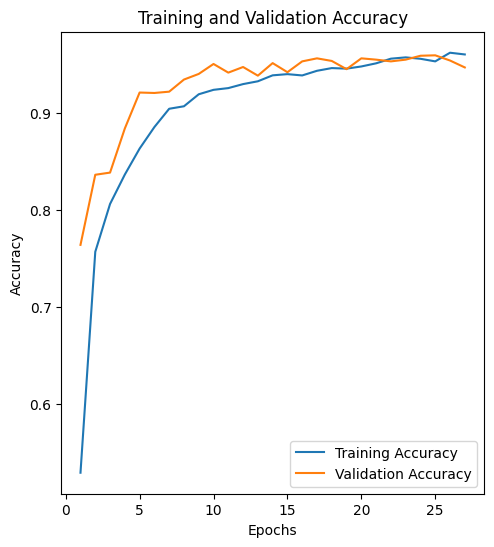

In [36]:
# Extract accuracy and loss values from history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_accuracy) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

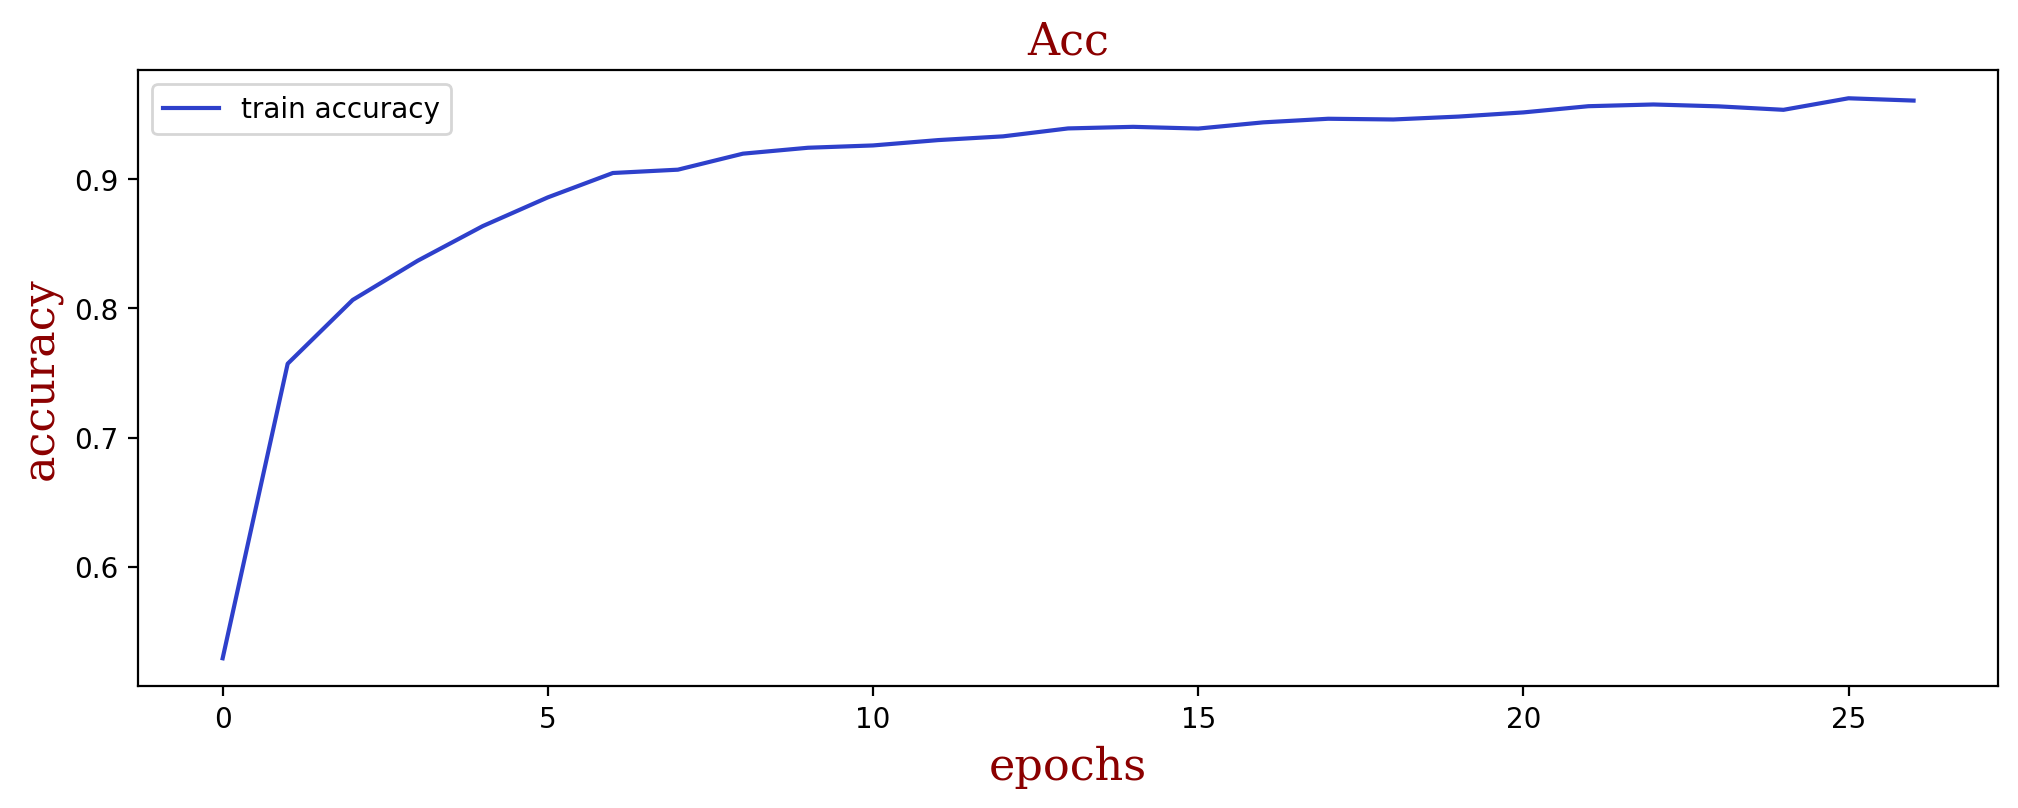

In [39]:
epochs = list(range(27))
acc = history.history['accuracy']
font2 = {'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 16}

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(epochs, acc, label='train accuracy', color='#2E40CB')
plt.xlabel('epochs', fontdict= font2)
plt.ylabel('accuracy', fontdict= font2)
plt.title('Acc', fontdict= font2)
plt.legend()
plt.show()

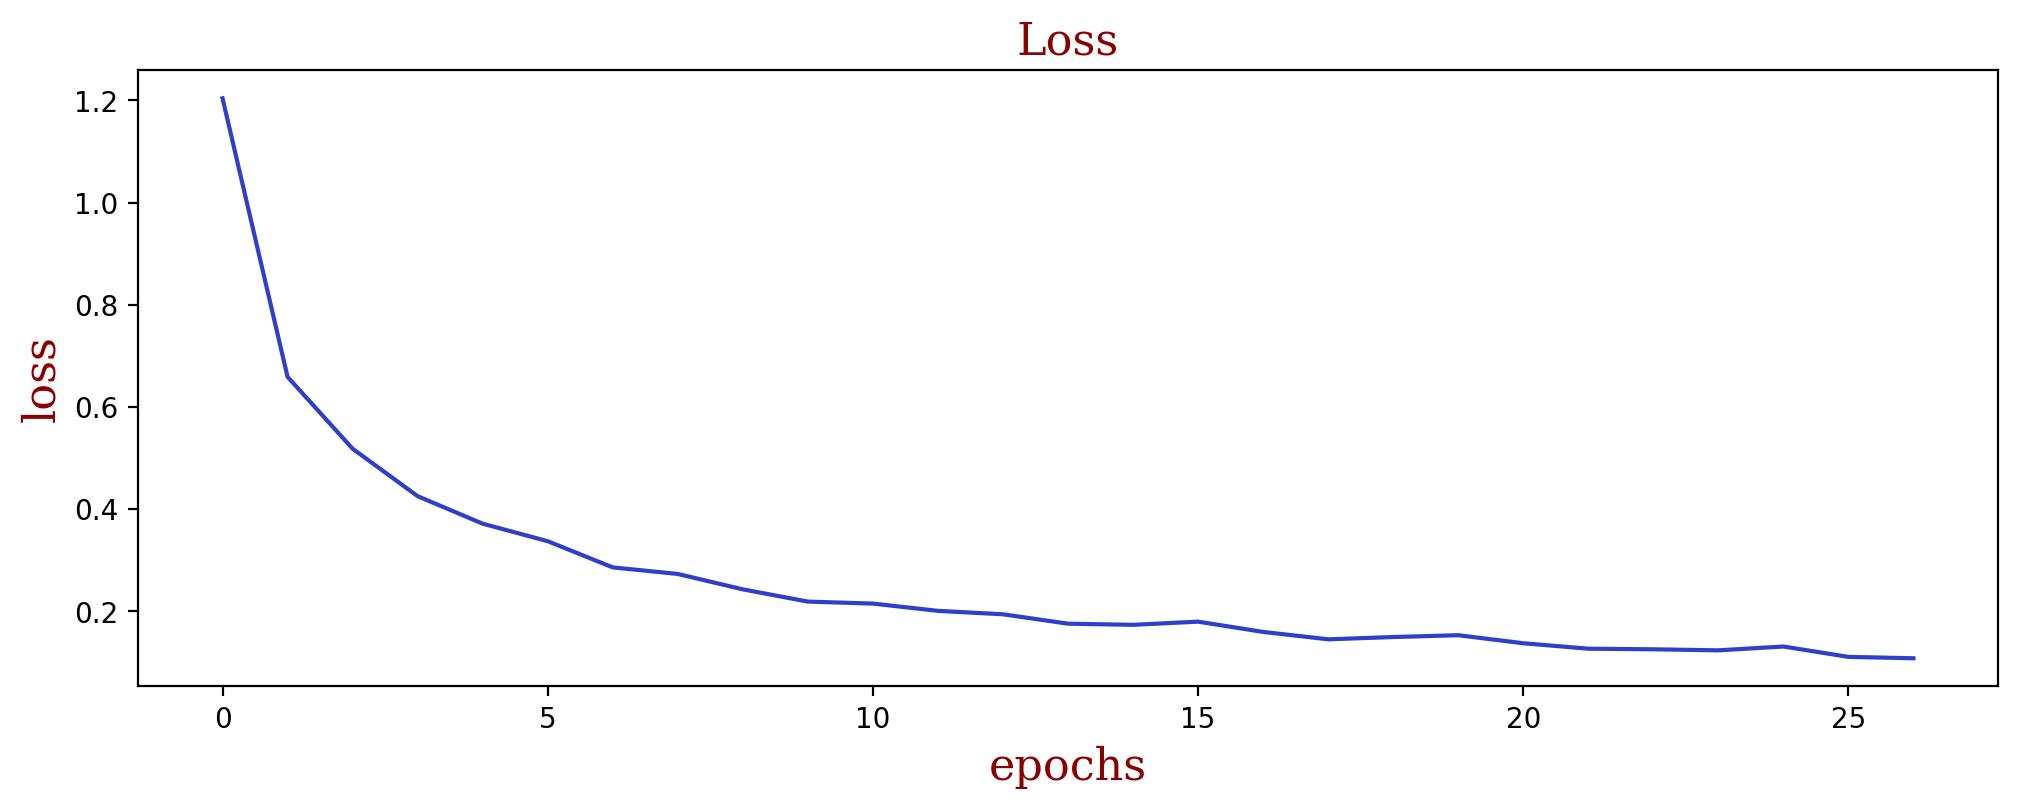

In [40]:
loss = history.history['loss']

plt.figure(figsize=(12, 4), dpi=200)
plt.plot(epochs, loss, label='train loss', color='#2E40CB')
plt.xlabel('epochs', fontdict= font2)
plt.ylabel('loss', fontdict= font2)
plt.title('Loss', fontdict= font2)
plt.show()

In [41]:
# Predict on the test set
y_pred_prob = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_pred

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


array([4, 5, 5, ..., 1, 4, 4])

In [42]:
# Your true labels for the test set are already 'y_test'
y_true = y_test
# Convert one-hot encoded y_true to class labels
y_true_labels = np.argmax(y_true, axis=1)
y_true_labels

array([4, 5, 5, ..., 1, 4, 4])

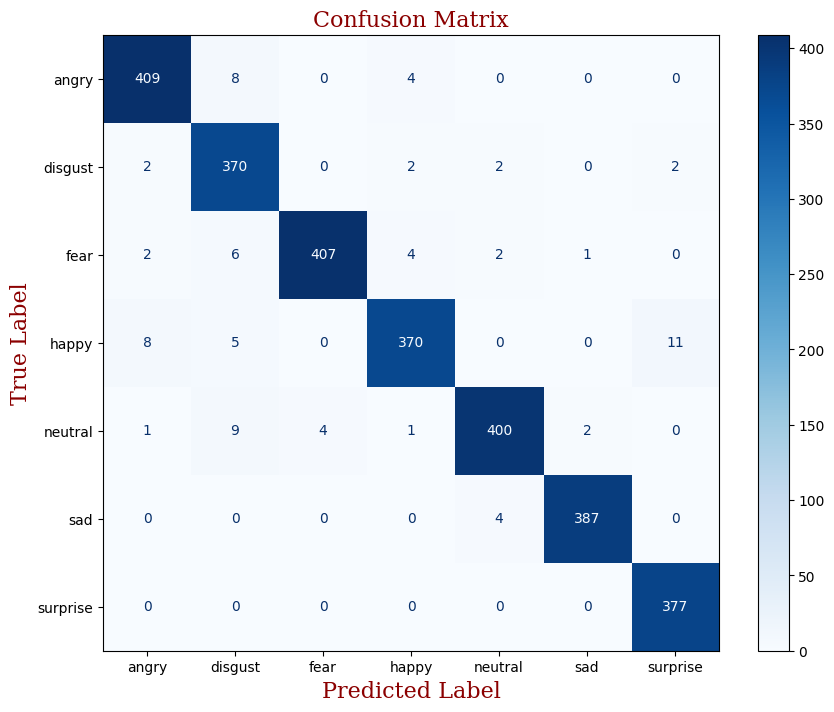

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_true_labels, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 8), dpi=100)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])  
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontdict={'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 16})
plt.xlabel('Predicted Label', fontdict={'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 16})
plt.ylabel('True Label', fontdict={'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 16})
plt.show()


In [44]:
from sklearn.metrics import f1_score

# Assuming y_true_labels and y_pred are already defined
f1 = f1_score(y_true_labels, y_pred, average='weighted')  # Use 'weighted' for multi-class classification
print(f'F1 Score: {f1:.4f}')


F1 Score: 0.9714


In [45]:
from sklearn.metrics import classification_report

report = classification_report(y_true_labels, y_pred, target_names=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])
print(report)


              precision    recall  f1-score   support

       angry       0.97      0.97      0.97       421
     disgust       0.93      0.98      0.95       378
        fear       0.99      0.96      0.98       422
       happy       0.97      0.94      0.95       394
     neutral       0.98      0.96      0.97       417
         sad       0.99      0.99      0.99       391
    surprise       0.97      1.00      0.98       377

    accuracy                           0.97      2800
   macro avg       0.97      0.97      0.97      2800
weighted avg       0.97      0.97      0.97      2800



Accuracy: 0.9714
Precision: 0.9719
Recall: 0.9714
F1 Score: 0.9714
ROC-AUC Score: 0.9989
              precision    recall  f1-score   support

       angry       0.97      0.97      0.97       421
     disgust       0.93      0.98      0.95       378
        fear       0.99      0.96      0.98       422
       happy       0.97      0.94      0.95       394
     neutral       0.98      0.96      0.97       417
         sad       0.99      0.99      0.99       391
    surprise       0.97      1.00      0.98       377

    accuracy                           0.97      2800
   macro avg       0.97      0.97      0.97      2800
weighted avg       0.97      0.97      0.97      2800



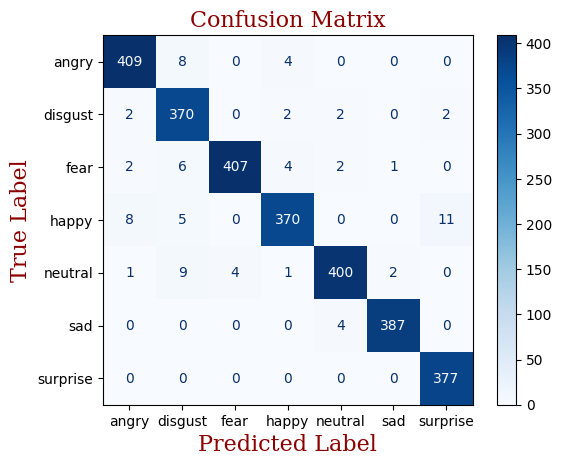

In [46]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Calculate metrics
accuracy = accuracy_score(y_true_labels, y_pred)
precision = precision_score(y_true_labels, y_pred, average='weighted')
recall = recall_score(y_true_labels, y_pred, average='weighted')
f1 = f1_score(y_true_labels, y_pred, average='weighted')

# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# ROC-AUC Score 
roc_auc = roc_auc_score(y_true_labels, y_pred_prob, multi_class='ovr')
print(f'ROC-AUC Score: {roc_auc:.4f}')

# Classification Report
report = classification_report(y_true_labels, y_pred, target_names=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])
print(report)

# Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontdict={'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 16})
plt.xlabel('Predicted Label', fontdict={'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 16})
plt.ylabel('True Label', fontdict={'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 16})
plt.show()
